<h1><center>Cruise Reviews - Trip Advisor - Models</center></h1>

![title](Screen.png)

## Importing Libraries & Defining functions

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pickle
from datetime import datetime

# Preprocessing
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#Model Assestment
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report,precision_score, recall_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

#Models
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings('ignore')
#Add settings for SNS

In [18]:
def save_pickle(element,file):
    with open(file, 'wb') as handle:
        pickle.dump(element, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_pickle(file):
    with open(file, 'rb') as handle:
        return pickle.load(handle)

## Loading Data

In [19]:
# Reviews Content
reviews = pd.read_csv('reviews_step_5.csv', index_col=0)
print(reviews.shape)
reviews.head(3)

(9596, 31)


,Unnamed: 0.1,ship_link,links,user_date,user_link,user_contributions,user_helpful_votes,stars,title,content,...,vader_title_compound,vader_title_neg,vader_title_neu,vader_title_pos,vader_content_compound,vader_content_neg,vader_content_neu,vader_content_pos,stars_grouped,word_count
0,0,/Cruise_Review-d15691636-Reviews-MSC_Meraviglia,/ShowUserReviews-g1-d15691636-r743487186-MSC_M...,Tony K|Yesterday,/Profile/L9746OCtonyk,62,5,4,MSC Meraviglia Yacht Club,We sailed on the MSC Meraviglia for the first ...,...,0.000,0.0,1.000,0.000,0.9979,0.066,0.780,0.154,Good Review,820
1,1,/Cruise_Review-d15691636-Reviews-MSC_Meraviglia,/ShowUserReviews-g1-d15691636-r743427041-MSC_M...,ann b|Yesterday,/Profile/bhayden,10,11,1,never again,This ship is a huge nightmare. I am in decent...,...,0.000,0.0,1.000,0.000,0.8902,0.108,0.728,0.165,Bad Review,159
2,2,/Cruise_Review-d15691636-Reviews-MSC_Meraviglia,/ShowUserReviews-g1-d15691636-r743305803-MSC_M...,Lsabina11|5 Feb,/Profile/Lsabina11,289,57,5,Awesome experience at great value,Four of us just came back from a MSC Meravigli...,...,0.891,0.0,0.159,0.841,0.9969,0.053,0.652,0.295,Good Review,219


## Preparing Features and Target

In [20]:
# Defining predictors
X = reviews[['vader_content_compound', 
                        'vader_content_neg',
                        'vader_content_neu', 
                        'vader_content_pos',
                        'word_count']]

#Separating content for train test split and subsequent tdif vectorisation
C = reviews.content

#Defining target
y = reviews.stars_grouped

print('Size of X: {}'.format(X.shape))
print('Size of C: {}'.format(C.shape))
print('Size of y: {}'.format(y.shape))

Size of X: (9596, 5)
Size of C: (9596,)
Size of y: (9596,)


## Train and Test Split

In [21]:
Xtrain, Xtest,Ctrain,Ctest, ytrain, ytest = train_test_split(X,C,y,test_size = 0.3, stratify = y, random_state = 14)

In [22]:
print(len(Xtrain),len(Xtest),len(Ctrain),len(Ctest),len(ytrain),len(ytest))

6717 2879 6717 2879 6717 2879


## TFID Vectorising

In [23]:
#Instantiating Vectoriser
content_tvec = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,1),stop_words = 'english',max_df=0.4, min_df=0.05)

#Fitting tfid based on Ctrain Data and transforming both train and test data.
train_matrix = content_tvec.fit_transform(Ctrain)
test_matrix = content_tvec.transform(Ctest)

#Saving Train TFID into DataFrame
train_tfid_df = pd.DataFrame(train_matrix.toarray(),
                            columns= list(map(lambda x : 'tfid - '+ x, list(content_tvec.get_feature_names()))),
                            index = Ctrain.index)

#Saving Test TFID into DataFrame
test_tfid_df = pd.DataFrame(test_matrix.toarray(),
                            columns=list(map(lambda x : 'tfid - '+ x, list(content_tvec.get_feature_names()))), 
                            index = Ctest.index)

In [24]:
#Joining data with tfid matrices
Xtrain = pd.concat([Xtrain,train_tfid_df], axis=1)
Xtest = pd.concat([Xtest,test_tfid_df], axis=1)
print(Xtrain.shape,Xtest.shape)

(6717, 310) (2879, 310)


## Standardising

In [25]:
# Keeping mean to work with Sparse Matrix
scaler = StandardScaler(with_mean = False)
Xtrain_std = pd.DataFrame(scaler.fit_transform(Xtrain),columns = Xtrain.columns, index = Xtrain.index)
Xtest_std = pd.DataFrame(scaler.transform(Xtest),columns = Xtest.columns, index = Xtest.index)

In [26]:
from scipy import sparse
X_std = pd.DataFrame(scaler.fit_transform(X),columns = X.columns, index = X.index)

Xtrain_std_spa = sparse.csr_matrix(Xtrain_std.values)
Xtest_std_spa = sparse.csr_matrix(Xtest_std.values)

## Assesing Models

### Estimating Baseline

In [28]:
##Estimating Baseline
baseline = ytrain.value_counts(normalize = True)[0]
baseline

0.6779812416257258

### Model Scorer

In [29]:
random_state = 14

In [30]:
model_results = {}

def grid(model_name,model_type,param_dict,Xtr,ytr,Xte,yte,scoring='roc_auc'):
    
    start = datetime.now()
    
    #Fitting grid
    grid = GridSearchCV(model_type,param_dict,n_jobs = -1,scoring=scoring,verbose =2,cv = 5).fit(Xtr,ytr)
    grid_time = datetime.now()
    print('Time\nGrid fitting took {}'.format(grid_time - start))
    
    #Extracting best model and predictions
    model = grid.best_estimator_
    yte_hat = model.predict(Xte)
    
    # binarising for roc_auc
    yte_bin = label_binarize(yte, classes=['Good Review','Bad Review'])
    yte_hat_bin = label_binarize(yte_hat, classes=['Good Review','Bad Review'])
    
    # cross validating for accuracy
    scores = cross_val_score(model,Xtr,ytr,cv = 5,scoring = 'accuracy')
    cv_time = datetime.now()
    print('CV took {}'.format(cv_time - grid_time))

    # additional calculations
    fpr, tpr, threshold = roc_curve(yte_bin, yte_hat_bin,pos_label = 1)
    roc_auc = auc(fpr, tpr)
    
    # storing results  
    model_results[model_name] = {
        'model': model,
        'accuracy train' : model.score(Xtr,ytr),
        'accuracy test' : model.score(Xte,yte),
        'accuracy cv' : np.mean(scores),
        'confusion' : confusion_matrix(yte,yte_hat,model.classes_),
        'report': classification_report(yte,yte_hat, labels = model.classes_),
        'precision': precision_score(yte,yte_hat, labels = model.classes_,pos_label ='Bad Review'),
        'recall': recall_score(yte,yte_hat, labels = model.classes_,pos_label ='Bad Review'),
         'AUC': roc_auc,
         'AUC CV':grid.best_score_
    }    

    #printing results
    print('\nModel Scores')
    print('Accuracy on train data: {}'.format(model_results[model_name]['accuracy train']))
    print('Accuracy on test data: {}'.format(model_results[model_name]['accuracy test']))
    print('Accuracy on CV: {}'.format(model_results[model_name]['accuracy cv']))
    print('Baseline: {}\n'.format(baseline))
    
    print('AUC CV: {}'.format(model_results[model_name]['AUC CV'])) 
    print('\nConfusion Matrix')
    print(model_results[model_name]['confusion'])    
    print('\nClassification Report')
    print(model_results[model_name]['report'])
    
    print('Best Estimator Parameters'.format(model_name))
    print(model.get_params())
    finish = datetime.now()
    return grid

## KNN

In [31]:
kneigh_dict = {
    'n_neighbors':[10,20,30],
    'weights':['uniform','distance'],
    'metric': ['euclidean','manhattan','cosine']  
}

kneigh_grid = grid('Combined - KNeighborsClassifier',KNeighborsClassifier(),kneigh_dict,
                   Xtrain_std_spa,ytrain,Xtest_std_spa,ytest)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

## Logistic Regression

In [28]:
#logistic regression parameter dictionaty
log_dict = {
    'Cs':[10],
    'penalty':['l1','l2'],
    'solver': ['liblinear']}

#logistic regression parameter dictionaty
log_grid = grid(
    'Combined - LogisticRegression - 2Grams',LogisticRegressionCV(random_state = random_state),log_dict, 
    Xtrain_std_spa,ytrain,
    Xtest_std_spa,ytest,
    scoring = 'roc_auc')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  3.7min remaining:  1.6min


KeyboardInterrupt: 

## Decision Trees

In [32]:
### Decision Tree Grid Dictionary
dtree_dict = {
    'max_depth':[2,3,4,6],
    'criterion':['gini','entropy'],
    'splitter': ['best','random']}

#Decision Tree regression parameter dictionaty
dtree_grid = grid(
    'Combined - DecisionTreeClassifier',DecisionTreeClassifier(random_state = random_state),dtree_dict, 
    Xtrain_std,ytrain,Xtest_std,ytest,scoring = 'roc_auc')

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.8s finished


Time
Grid fitting took 0:00:03.992931
CV took 0:00:00.721087

Model Scores
Accuracy on train data: 0.8262617239839214
Accuracy on test data: 0.8197290725946509
Accuracy on CV: 0.8220928403006772
Baseline: 0.6779812416257258

AUC CV: 0.8811046360610199

Confusion Matrix
[[ 667  260]
 [ 259 1693]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.72      0.72      0.72       927
 Good Review       0.87      0.87      0.87      1952

    accuracy                           0.82      2879
   macro avg       0.79      0.79      0.79      2879
weighted avg       0.82      0.82      0.82      2879

Best Estimator Parameters
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 14, 'splitter': 'best

## Naive Bayes

In [ ]:
#Decision Tree regression parameter dictionaty
bayes_g_dict = {
    'var_smoothing':np.logspace(-20,-1,22)}

#Decision Tree regression parameter dictionaty
bayes_g_grid = grid(
    'Combined - NaiveBayes',naive_bayes.GaussianNB(),bayes_g_dict, 
    Xtrain_std,ytrain,
    Xtest_std,ytest,
    scoring = 'roc_auc')

## Bagging

In [24]:
bag_dict = {
    'base_estimator':[DecisionTreeClassifier(max_depth=4),
                      DecisionTreeClassifier(max_depth=30),
                      DecisionTreeClassifier(max_depth=50)],
    'n_estimators' : [200,220],
    'max_samples':[0.8,1]}

bag_grid = grid('Combined - BaggingClassifier',BaggingClassifier(random_state=random_state),bag_dict, 
                Xtrain_std_spa,ytrain,
                Xtest_std_spa,ytest,
                scoring = 'roc_auc')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Exception in thread QueueManagerThread:
Traceback (most recent call last):
  File "/Users/hernan/opt/anaconda3/envs/textacy/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/hernan/opt/anaconda3/envs/textacy/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/hernan/opt/anaconda3/envs/textacy/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py", line 747, in _queue_management_worker
    recursive_terminate(p)
  File "/Users/hernan/opt/anaconda3/envs/textacy/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/backend/utils.py", line 28, in recursive_terminate
    _recursive_terminate_without_psutil(process)
  File "/Users/hernan/opt/anaconda3/envs/textacy/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/backend/utils.py", line 53, in _recursive_termi

KeyboardInterrupt: 

## Random Forest

In [36]:
rforest_dict = {
    'min_impurity_decrease':[0.0,0.001,0.005,0.01,0.05],
    'criterion': ['gini','entropy'],
    'max_depth': [10,30,50,100,120]}

rforest_grid = grid('Combined - RandomForest',RandomForestClassifier(random_state=random_state),rforest_dict,
                    Xtrain_std_spa,ytrain, Xtest_std_spa, ytest)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    9.6s finished


Time
Grid fitting took 0:00:09.927570
CV took 0:00:01.219431

Model Scores
Accuracy on train data: 0.9004019651630192
Accuracy on test data: 0.8430010420284821
Accuracy on CV: 0.8378789171774278
Baseline: 0.6779812416257258

AUC CV: 0.895977154645591

Confusion Matrix
[[ 618  309]
 [ 143 1809]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.81      0.67      0.73       927
 Good Review       0.85      0.93      0.89      1952

   micro avg       0.84      0.84      0.84      2879
   macro avg       0.83      0.80      0.81      2879
weighted avg       0.84      0.84      0.84      2879

Best Estimator Parameters
{'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 50, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.001, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, '

## Ada Boost

In [49]:

ada_dict = {
    'base_estimator':[DecisionTreeClassifier(max_depth=5),
                     DecisionTreeClassifier(max_depth=10),
                     DecisionTreeClassifier(max_depth=20)],
    'n_estimators' : [80,120],
    'learning_rate':[.5,.9,1]}

ada_grid = grid('Combined - AdaBoostClassifier',AdaBoostClassifier(random_state=random_state),ada_dict,
               Xtrain_std_spa,ytrain, Xtest_std_spa, ytest)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  7.7min finished


Time
Grid fitting took 0:08:35.574034
CV took 0:03:36.653776

Model Scores
Accuracy on train data: 1.0
Accuracy on test data: 0.8433483848558527
Accuracy on CV: 0.8430852548861608
Baseline: 0.6779812416257258

AUC CV: 0.9027218761672566

Confusion Matrix
[[ 621  306]
 [ 145 1807]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.81      0.67      0.73       927
 Good Review       0.86      0.93      0.89      1952

   micro avg       0.84      0.84      0.84      2879
   macro avg       0.83      0.80      0.81      2879
weighted avg       0.84      0.84      0.84      2879

Best Estimator Parameters
{'algorithm': 'SAMME.R', 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 20, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_impurity_split': None, 'base_estimator__min_samples_leaf': 1, 'b

## Gradient Boosting Classifier

In [46]:
gboost_dict = {
    'n_estimators':[50,100,150,200],
    'loss' : ['exponential'],
    'learning_rate':[0.1,0.5,1],
    'criterion': ['mse'],
    'max_depth': [10,20]}

gboost_grid = grid('Combined - Gradient Boosting',GradientBoostingClassifier(random_state=random_state)
                   ,gboost_dict, Xtrain_std_spa,ytrain, Xtest_std_spa, ytest)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 10.9min finished


Time
Grid fitting took 0:11:36.254775
CV took 0:02:56.445169

Model Scores
Accuracy on train data: 1.0
Accuracy on test data: 0.8513372698853768
Accuracy on CV: 0.8478515942776591
Baseline: 0.6779812416257258

AUC CV: 0.9089918524528298

Confusion Matrix
[[ 653  274]
 [ 154 1798]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.81      0.70      0.75       927
 Good Review       0.87      0.92      0.89      1952

   micro avg       0.85      0.85      0.85      2879
   macro avg       0.84      0.81      0.82      2879
weighted avg       0.85      0.85      0.85      2879

Best Estimator Parameters
{'criterion': 'mse', 'init': None, 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_iter_no_change': None, 'presort': 'au

## Support Vector Machines

In [62]:
# Linear SVM
svm_linear_dict = {'C': np.logspace(-2, 2, 11),
                  'fit_intercept': [True, False],
                  'loss':['hinge'],
                 'penalty':['l2']}


# Linear
gboost_svm_lin = grid('Combined - SVM - Linear',LinearSVC(random_state=random_state)
                   ,svm_linear_dict, Xtrain_std_spa,ytrain, Xtest_std_spa, ytest)

    

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:   17.4s finished


Time
Grid fitting took 0:00:17.488792
CV took 0:00:00.290309

Model Scores
Accuracy on train data: 0.8794104510942385
Accuracy on test data: 0.8523792983674887
Accuracy on CV: 0.8497850088931044
Baseline: 0.6779812416257258

AUC CV: 0.9143506655866503

Confusion Matrix
[[ 668  259]
 [ 166 1786]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.80      0.72      0.76       927
 Good Review       0.87      0.91      0.89      1952

   micro avg       0.85      0.85      0.85      2879
   macro avg       0.84      0.82      0.83      2879
weighted avg       0.85      0.85      0.85      2879

Best Estimator Parameters
{'C': 0.01, 'class_weight': None, 'dual': True, 'fit_intercept': False, 'intercept_scaling': 1, 'loss': 'hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 14, 'tol': 0.0001, 'verbose': 0}


In [64]:
#rbf 
rbf_dict = {
    'kernel':['rbf'],
    'gamma' : np.logspace(-5, 2, 10),
    'C' : np.logspace(-3, 2, 10),}

svm_rbf_grid = grid('Combined - SVM - RBF',SVC(random_state=random_state)
                   ,rbf_dict, Xtrain_std_spa,ytrain, Xtest_std_spa, ytest)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 22.8min finished


Time
Grid fitting took 0:22:53.709743
CV took 0:00:24.716442

Model Scores
Accuracy on train data: 0.9114187881494715
Accuracy on test data: 0.8544633553317124
Accuracy on CV: 0.8515700573651334
Baseline: 0.6779812416257258

AUC CV: 0.9170442922941925

Confusion Matrix
[[ 624  303]
 [ 116 1836]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.84      0.67      0.75       927
 Good Review       0.86      0.94      0.90      1952

   micro avg       0.85      0.85      0.85      2879
   macro avg       0.85      0.81      0.82      2879
weighted avg       0.85      0.85      0.85      2879

Best Estimator Parameters
{'C': 0.5994842503189409, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.0021544346900318843, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 14, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [67]:
#poly 
poly_dict = {
    'kernel':['poly'],
    'gamma' : np.logspace(-5, 2, 10),
    'degree' : [2,3],
    'C' : np.logspace(-3, 2, 10),}

svm_poly_grid = grid('Combined - SVM - Poly',SVC(random_state=random_state)
                   ,poly_dict, Xtrain_std_spa,ytrain, Xtest_std_spa, ytest)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 39.7min finished


Time
Grid fitting took 0:39:49.321398
CV took 0:00:28.006334

Model Scores
Accuracy on train data: 0.9017418490397499
Accuracy on test data: 0.8534213268496006
Accuracy on CV: 0.8488898232188044
Baseline: 0.6779812416257258

AUC CV: 0.9175931149900948

Confusion Matrix
[[ 608  319]
 [ 103 1849]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.86      0.66      0.74       927
 Good Review       0.85      0.95      0.90      1952

   micro avg       0.85      0.85      0.85      2879
   macro avg       0.85      0.80      0.82      2879
weighted avg       0.85      0.85      0.85      2879

Best Estimator Parameters
{'C': 0.01291549665014884, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 2, 'gamma': 0.01291549665014884, 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': 14, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [70]:
sigmoid_dict = {
    'kernel':['sigmoid'],
    'gamma' : np.logspace(-5, 2, 10),
    'C' : np.logspace(-3, 2, 10)}

sig_poly_grid = grid('Combined - SVM - Sigmoid',SVC(random_state=random_state)
                   ,sigmoid_dict, Xtrain_std_spa,ytrain, Xtest_std_spa, ytest)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 16.6min finished


Time
Grid fitting took 0:16:43.184222
CV took 0:00:27.123060

Model Scores
Accuracy on train data: 0.8661604883132351
Accuracy on test data: 0.8506425842306357
Accuracy on CV: 0.8499329308304656
Baseline: 0.6779812416257258

AUC CV: 0.9168459926929702

Confusion Matrix
[[ 603  324]
 [ 106 1846]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.85      0.65      0.74       927
 Good Review       0.85      0.95      0.90      1952

   micro avg       0.85      0.85      0.85      2879
   macro avg       0.85      0.80      0.82      2879
weighted avg       0.85      0.85      0.84      2879

Best Estimator Parameters
{'C': 7.742636826811277, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 5.994842503189409e-05, 'kernel': 'sigmoid', 'max_iter': -1, 'probability': False, 'random_state': 14, 'shrinking': True, 'tol': 0.001, 'verbose': False}


## Neural Networks - Multi-Layer-Perceptron

In [23]:
MLP_dict = {'hidden_layer_sizes' : [(20,20),(40,40),(60,60),(80,80),(20,20,20),(60,60,60)],
       'activation' : ['identity', 'logistic', 'tanh', 'relu'],
       'alpha': np.logspace(-5,4,10)}

mlp_grid = grid('Combined - MLP',MLPClassifier(solver='lbfgs',
                    random_state=random_state,
                    batch_size='auto',early_stopping = True, n_iter_no_change=10), 
                MLP_dict,Xtrain_std_spa,ytrain, Xtest_std_spa, ytest)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 11.9min finished


Time
Grid fitting took 0:11:59.248844
CV took 0:00:24.993539

Model Scores
Accuracy on train data: 0.8700312639571237
Accuracy on test data: 0.8541160125043418
Accuracy on CV: 0.854099818774498
Baseline: 0.6779812416257258

AUC CV: 0.9193207834692809

Confusion Matrix
[[ 623  304]
 [ 116 1836]]

Classification Report
              precision    recall  f1-score   support

  Bad Review       0.84      0.67      0.75       927
 Good Review       0.86      0.94      0.90      1952

   micro avg       0.85      0.85      0.85      2879
   macro avg       0.85      0.81      0.82      2879
weighted avg       0.85      0.85      0.85      2879

Best Estimator Parameters
{'activation': 'logistic', 'alpha': 100.0, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (80, 80), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.

In [54]:
save_pickle(model_results,'model_results.pkl')

## Comparing Results

In [11]:
model_results = load_pickle('model_results.pkl')

In [12]:
model_results.keys()

dict_keys(['Combined - LogisticRegression', 'Combined - KNeighborsClassifier', 'Combined - DecisionTreeClassifier', 'Combined - NaiveBayes', 'Combined - BaggingClassifier', 'Combined - RandomForest', 'Combined - Gradient Boosting', 'Combined - AdaBoostClassifier', 'Combined - SVM - Linear', 'Combined - SVM - RBF', 'Combined - SVM - Poly', 'Combined - SVM - Sigmoid', 'Combined - MLP'])

In [33]:
model_resultsumm= {
    'Model Name': [x for x in model_results.keys()],
    'AUC CV': [model_results[x]['AUC CV'] for x in model_results.keys()],
    'Accuracy CV': [model_results[x]['accuracy cv'] for x in model_results.keys()],
    'Accuracy on Test': [model_results[x]['accuracy test'] for x in model_results.keys()]
}

resultsDF = pd.DataFrame(model_resultsumm).sort_values(by = 'AUC CV', ascending = True)
resultsDF

#fig, ax = plt.subplots(figsize = (5,8));
#resultsDF.set_index('Model Name').plot(kind= 'barh', ax = ax);

,Model Name,AUC CV,Accuracy CV,Accuracy on Test
0,Combined - DecisionTreeClassifier,0.881105,0.822093,0.819729


In [34]:
dtree = model_results['Combined - DecisionTreeClassifier']['model']

In [35]:
import warnings
import numpy as np
import scipy.stats as stats
from sklearn.tree import DecisionTreeRegressor
from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus

from ipywidgets import *
from IPython.display import display
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc("figure", figsize=(9, 7))
sns.set(font_scale=1.5)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

warnings.simplefilter('ignore')

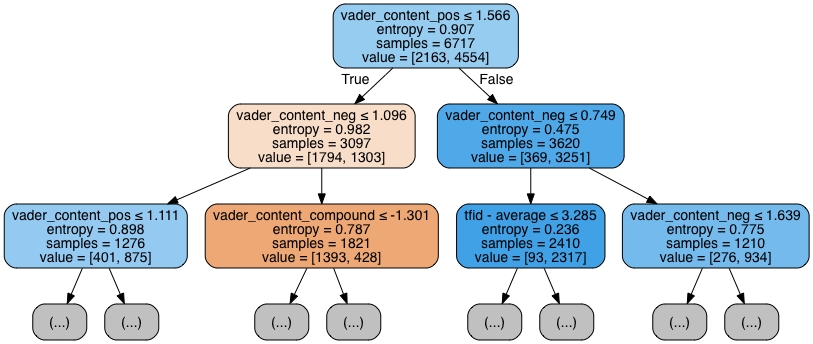

In [42]:
dot_data = StringIO()
export_graphviz(dtree,
                out_file=dot_data,
                max_depth=2,
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=Xtrain_std.columns
                )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

In [41]:
pd.DataFrame(list(zip(Xtrain_std.columns, dtree.feature_importances_)), 
             columns=['Feature', 'Importance']
            ).sort_values(by='Importance', ascending=False)[:10]

,Feature,Importance
3,vader_content_pos,0.592845
1,vader_content_neg,0.325404
0,vader_content_compound,0.048850
22,tfid - average,0.012563
2,vader_content_neu,0.009330
198,tfid - ok,0.008025
297,tfid - wasn,0.002984
206,tfid - package,0.000000
212,tfid - person,0.000000
211,tfid - perfect,0.000000


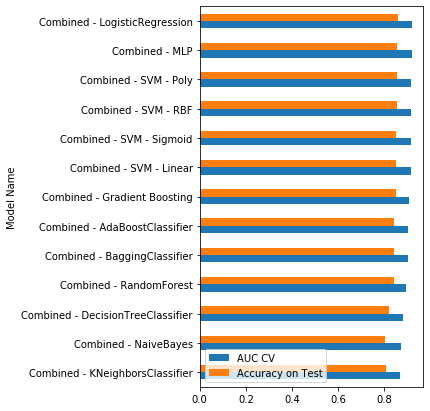

In [41]:
fig, ax = plt.subplots(figsize = (4,7));
resultsDF.set_index('Model Name')[['AUC CV','Accuracy on Test']].plot(kind = 'barh', ax = ax);
ax.legend(loc = 'lower left');

## Model Analysis

In [1]:
coefficient_df = pd.DataFrame(model_results['Combined - LogisticRegression']['model'].coef_.reshape(-1,1), index = Xtrain_std.columns,columns = ['coefficient'])
is_0 = coefficient_df.coefficient.apply(lambda x: np.isclose(x,0))

NameError: name 'pd' is not defined

In [59]:
is_0 = coefficient_df.coefficient.apply(lambda x: np.isclose(x,0))

In [74]:
coefficient_df[~is_0].sort_values(by= 'coefficient', ascending=False)[:50]

,coefficient
vader_content_pos,1.058893
tfid - loved,0.255614
tfid - perfect,0.229823
tfid - enjoyed,0.215362
tfid - plenty,0.213059
tfid - excellent,0.140848
tfid - amazing,0.125651
tfid - fantastic,0.125537
tfid - included,0.109600
tfid - wonderful,0.107034


In [94]:
reviews.content.iloc[1]

'This ship is a huge nightmare.  I am in decent shape, but walking to any venue was a major deal, partly because there were no elevators in the aft section......how about that !!Here\'s a rundown:Bar, wait staff, room attendants are good, efficient, and polite.Front desk staff - a complete joke.  No matter the question, they have to send a message to the head office.  We requested a room change, the answer came back 4 days later .... !  what\'s the point ?  A direct question:  "Do you have a more central room available ?"  They don\'t know.  WHY?Food:  Mediocre at best.  First suggestion is to hire a pastry/dessert chef.  The desserts are pathetic.  Second suggestion:  No one eats al dente carrots.  Raw carrots, yes, Cooked carrots should be fork tender.  Next bulletin:  Most Americans don\'t like tough beef.  Maybe the Europeans don\'t care, but somehow your competition is able to get tender US beef on their cruises from Miami.Good point:  The breads are excellent.'

## Making it more efficient

In [89]:
word_type_df = load_pickle('word_type.pkl')

In [91]:
word_type_df.head(3)

,ADJ,ADP,ADV,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,SCONJ,SPACE,SYM,VERB,X,word_count,stars_grouped
0,2nd fair stunning awesome amazing smooth simil...,unlike,pretty greatly slightly anymore unfortunately ...,and/or,,,time sailing pros cons trip promenade screen c...,2020 2 2 3 2 3,,,msc meraviglia january western caribbean msc y...,like despite,...,/,sailed balanced found improve having sailed ex...,,386,Good Review
1,huge decent major aft good efficient polite co...,,partly matter later best maybe,,,yes,ship nightmare shape venue deal elevators sect...,4,,,why?food mediocre al dente carrots americans e...,,,/,walking wait send requested came know hire eat...,,107,Bad Review
2,happy wonderful negative worried large beautif...,,little freshly onboard highly,,,,cruise experience reviews complaints ship faci...,"5,000",,,msc meraviglia caribbean shampoo msc meraviglia,,,,came read ate like eat baked order having incl...,i’ve,108,Good Review


In [93]:
word_type_df.apply(lambda x: x['ADJ']+' '+x['ADV']+' '+x['VERB'], axis = 1)

0       2nd fair stunning awesome amazing smooth simil...
1       huge decent major aft good efficient polite co...
2       happy wonderful negative worried large beautif...
3       bad excellent small little ready normal small ...
4       important worried long long wrong half quick e...
                              ...                        
9602    interesting clean clean tired unorganized  cro...
9603    charming nice proper efficient true profession...
9604    second beautiful great friendly good best beau...
9605    transatlantic long interesting good limited ni...
9606    great great great annoyed great long nice big ...
Length: 9596, dtype: object